# Multinomial and Ordinal Regression

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats 
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.metrics import roc_curve, auc, classification_report
from statsmodels.miscmodels.ordinal_model import OrderedModel
import warnings
warnings.filterwarnings('ignore')

# Example 1: Breakfast

File `cereal.xlsx`

Variables:
- age - age in years
- marital_status -  marital status (Married, Unmarried)
- lifestyle - lifestyle (Inactive, Active)
- breakfast - breakfast choice (Cereal, Oatmeal, Breakfast Bar)
- gender - gender (Female, Male)

In [2]:
df = pd.read_excel('cereal.xlsx')
df.head(25)

,age,marital_status,lifestyle,breakfast,gender
0,21,Married,Active,Breakfast Bar,Female
1,21,Married,Active,Breakfast Bar,Female
2,21,Married,Active,Breakfast Bar,Male
3,21,Married,Active,Breakfast Bar,Male
4,21,Married,Active,Breakfast Bar,Female
5,22,Married,Active,Breakfast Bar,Female
6,22,Married,Active,Breakfast Bar,Female
7,22,Married,Active,Breakfast Bar,Female
8,22,Married,Active,Breakfast Bar,Female
9,22,Married,Active,Breakfast Bar,Female


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             880 non-null    int64 
 1   marital_status  880 non-null    object
 2   lifestyle       880 non-null    object
 3   breakfast       880 non-null    object
 4   gender          880 non-null    object
dtypes: int64(1), object(4)
memory usage: 34.5+ KB


In [4]:
for t in df.dtypes.unique():
     print('Type: {}\n{}\n'.format(t, df.dtypes[df.dtypes==t].index.values))

Type: int64
['age']

Type: object
['marital_status' 'lifestyle' 'breakfast' 'gender']



In [5]:
missing = (df.isna().sum() / len(df)) * 100
missing = missing[missing > 0].sort_values(ascending=False)
missing = pd.DataFrame({'Percent of missing values' : missing})
missing

,Percent of missing values


### Dependent variable

In [6]:
df['breakfast'].value_counts()

breakfast
Cereal           339
Oatmeal          310
Breakfast Bar    231
Name: count, dtype: int64

### Independent variables

In [7]:
df['age'].describe()

count    880.000000
mean      49.885227
std       18.820311
min       21.000000
25%       33.000000
50%       51.000000
75%       67.000000
max       81.000000
Name: age, dtype: float64

In [8]:
df['marital_status'].value_counts()  # reference group Unmarried

marital_status
Married      577
Unmarried    303
Name: count, dtype: int64

In [9]:
marital_status_dummies=pd.get_dummies(df.marital_status, prefix='marital_status', prefix_sep='_', dtype=int)
marital_status_dummies.head()

,marital_status_Married,marital_status_Unmarried
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [10]:
df['lifestyle'].value_counts()  # reference group Inactive

lifestyle
Inactive    474
Active      406
Name: count, dtype: int64

In [11]:
lifestyle_dummies=pd.get_dummies(df.lifestyle, prefix='lifestyle', prefix_sep='_', dtype=int)
lifestyle_dummies.head()

,lifestyle_Active,lifestyle_Inactive
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [12]:
df['gender'].value_counts()  # reference group Male

gender
Female    456
Male      424
Name: count, dtype: int64

In [13]:
gender_dummies=pd.get_dummies(df.gender, prefix='gender', prefix_sep='_', dtype=int)
gender_dummies.head()

,gender_Female,gender_Male
0,1,0
1,1,0
2,0,1
3,0,1
4,1,0


In [14]:
df = pd.concat([df, marital_status_dummies, lifestyle_dummies, gender_dummies], axis=1) 
df

,age,marital_status,lifestyle,breakfast,gender,marital_status_Married,marital_status_Unmarried,lifestyle_Active,lifestyle_Inactive,gender_Female,gender_Male
0,21,Married,Active,Breakfast Bar,Female,1,0,1,0,1,0
1,21,Married,Active,Breakfast Bar,Female,1,0,1,0,1,0
2,21,Married,Active,Breakfast Bar,Male,1,0,1,0,0,1
3,21,Married,Active,Breakfast Bar,Male,1,0,1,0,0,1
4,21,Married,Active,Breakfast Bar,Female,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
875,79,Unmarried,Inactive,Oatmeal,Male,0,1,0,1,0,1
876,80,Unmarried,Inactive,Oatmeal,Male,0,1,0,1,0,1
877,80,Unmarried,Inactive,Oatmeal,Female,0,1,0,1,1,0
878,80,Unmarried,Inactive,Oatmeal,Female,0,1,0,1,1,0


### Preliminary analysis of relationships between dependent variable and predictors

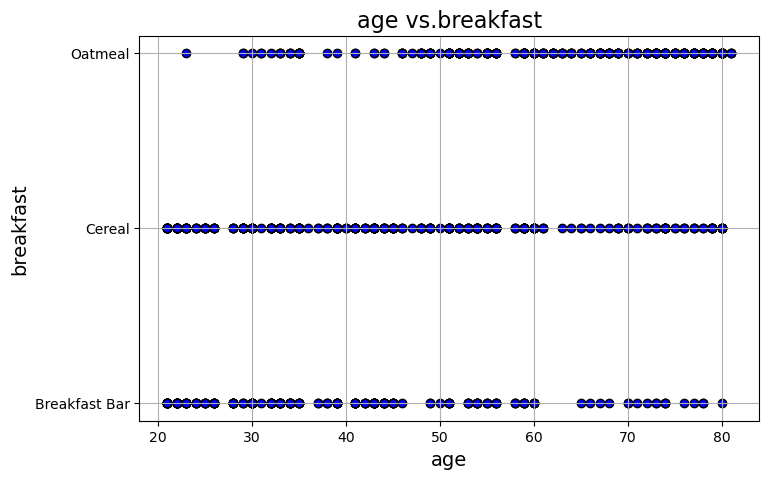

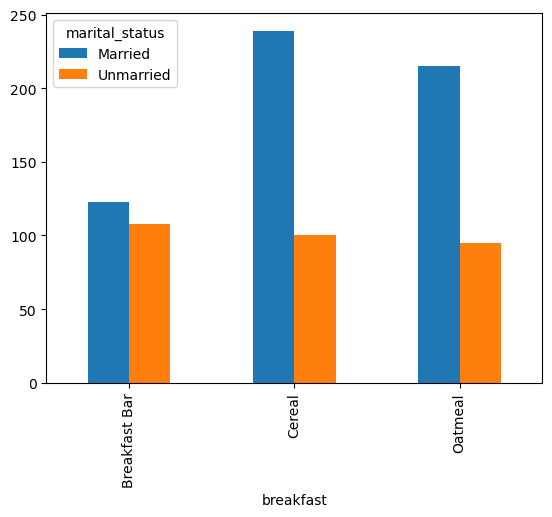

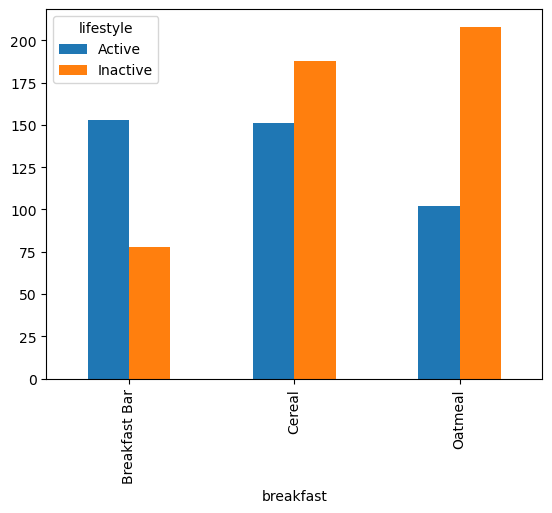

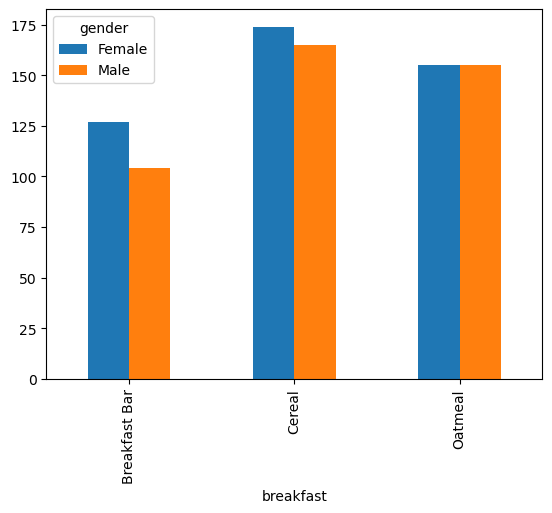

In [15]:
for c in df.columns:
    if c == 'age':
        plt.figure(figsize=(8,5))
        plt.title('{} vs.breakfast'.format(c), fontsize=16)
        plt.scatter(x=df[c], y=df.breakfast, color='blue',edgecolor='k')
        plt.grid(True)
        plt.xlabel(c, fontsize=14)
        plt.ylabel('breakfast', fontsize=14)
        plt.show()
    elif c == 'marital_status' or c == 'lifestyle' or c=='gender':
        ct = pd.crosstab(df.breakfast, df[c])
        ct.plot.bar()

# Multinomial Regression

https://www.statsmodels.org/devel/generated/statsmodels.discrete.discrete_model.MNLogit.html

In [16]:
df_model1 = df.dropna(subset=['breakfast', 'age', 'marital_status_Married', 'lifestyle_Active', 'gender_Female'])
df_model1.shape

(880, 11)

In [17]:
df_model1.reset_index(drop=True, inplace=True)
df_model1

,age,marital_status,lifestyle,breakfast,gender,marital_status_Married,marital_status_Unmarried,lifestyle_Active,lifestyle_Inactive,gender_Female,gender_Male
0,21,Married,Active,Breakfast Bar,Female,1,0,1,0,1,0
1,21,Married,Active,Breakfast Bar,Female,1,0,1,0,1,0
2,21,Married,Active,Breakfast Bar,Male,1,0,1,0,0,1
3,21,Married,Active,Breakfast Bar,Male,1,0,1,0,0,1
4,21,Married,Active,Breakfast Bar,Female,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
875,79,Unmarried,Inactive,Oatmeal,Male,0,1,0,1,0,1
876,80,Unmarried,Inactive,Oatmeal,Male,0,1,0,1,0,1
877,80,Unmarried,Inactive,Oatmeal,Female,0,1,0,1,1,0
878,80,Unmarried,Inactive,Oatmeal,Female,0,1,0,1,1,0


In [18]:
x_mult = df_model1[['age', 'marital_status_Married', 'lifestyle_Active', 'gender_Female']]
y = df_model1['breakfast']
x_mult_constant = sm.add_constant(x_mult)

In [19]:
model1 = sm.MNLogit(y, x_mult_constant).fit()
print(model1.summary())

Optimization terminated successfully.
         Current function value: 0.878740
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:              breakfast   No. Observations:                  880
Model:                        MNLogit   Df Residuals:                      870
Method:                           MLE   Df Model:                            8
Date:                Wed, 29 Oct 2025   Pseudo R-squ.:                  0.1909
Time:                        13:21:52   Log-Likelihood:                -773.29
converged:                       True   LL-Null:                       -955.78
Covariance Type:            nonrobust   LLR p-value:                 5.733e-74
      breakfast=Cereal       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.4326      0.313     -1.384      0.166      -1.045      

The model is statistically significant and explains 19% of the variability in the values of the dependent variable.

In [20]:
coefs = model1.params
coefs.columns = ['Cereal_VS_Breakfast_Bar', 'Outmeal_VS_Breakfast_Bar']
coefs

,Cereal_VS_Breakfast_Bar,Outmeal_VS_Breakfast_Bar
const,-0.432580,-4.582323
age,0.021073,0.092312
marital_status_Married,0.722492,1.023682
lifestyle_Active,-0.791888,-0.964191
gender_Female,-0.134973,-0.142028


In [21]:
coefs['OddsRatio_Cereal_VS_Breakfast_Bar'] = np.exp(coefs.Cereal_VS_Breakfast_Bar)
coefs['OddsRatio_Outmeal_VS_Breakfast_Bar'] = np.exp(coefs.Outmeal_VS_Breakfast_Bar)
coefs

,Cereal_VS_Breakfast_Bar,Outmeal_VS_Breakfast_Bar,OddsRatio_Cereal_VS_Breakfast_Bar,OddsRatio_Outmeal_VS_Breakfast_Bar
const,-0.432580,-4.582323,0.648833,0.010231
age,0.021073,0.092312,1.021296,1.096707
marital_status_Married,0.722492,1.023682,2.059560,2.783423
lifestyle_Active,-0.791888,-0.964191,0.452989,0.381292
gender_Female,-0.134973,-0.142028,0.873739,0.867597


### Interpreting the values of the regression coefficients

TBD

### Confusion Matrix

In [22]:
cm = model1.pred_table()
cm

array([[ 84., 119.,  28.],
       [ 64., 183.,  92.],
       [  7.,  82., 221.]])

In [23]:
pd.DataFrame(cm, index=['1-st','2-nd', '3-rd'],
columns=['predicted_1-st', 'predicted_2-nd', 'predicted_3-rd'])

,predicted_1-st,predicted_2-nd,predicted_3-rd
1-st,84.0,119.0,28.0
2-nd,64.0,183.0,92.0
3-rd,7.0,82.0,221.0


In [24]:
accuracy = np.diag(cm).sum()/cm.sum()
print('Accuracy: {}'.format(accuracy))

Accuracy: 0.5545454545454546


### Saving the predicted probabilities of each event for each observation

In [25]:
predicted = pd.DataFrame(model1.predict())
predicted.columns = ['BB', 'C', 'O']
predicted

,BB,C,O
0,0.529445,0.435897,0.034657
1,0.529445,0.435897,0.034657
2,0.495606,0.467001,0.037393
3,0.495606,0.467001,0.037393
4,0.529445,0.435897,0.034657
...,...,...,...
875,0.051381,0.176167,0.772452
876,0.047644,0.166831,0.785526
877,0.054454,0.166604,0.778942
878,0.054454,0.166604,0.778942


In [26]:
# the sum of the three probabilities is 1
predicted['BB'] + predicted ['C'] + predicted ['O']

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
875    1.0
876    1.0
877    1.0
878    1.0
879    1.0
Length: 880, dtype: float64

In [27]:
predicted['predicted_group'] = predicted.idxmax(axis=1)
predicted
# predicted value of the dependent variable 

,BB,C,O,predicted_group
0,0.529445,0.435897,0.034657,BB
1,0.529445,0.435897,0.034657,BB
2,0.495606,0.467001,0.037393,BB
3,0.495606,0.467001,0.037393,BB
4,0.529445,0.435897,0.034657,BB
...,...,...,...,...
875,0.051381,0.176167,0.772452,O
876,0.047644,0.166831,0.785526,O
877,0.054454,0.166604,0.778942,O
878,0.054454,0.166604,0.778942,O


In [28]:
res = pd.concat([df_model1, predicted['predicted_group']], axis=1)
res  # add the predicted value to the original dataframe

,age,marital_status,lifestyle,breakfast,gender,marital_status_Married,marital_status_Unmarried,lifestyle_Active,lifestyle_Inactive,gender_Female,gender_Male,predicted_group
0,21,Married,Active,Breakfast Bar,Female,1,0,1,0,1,0,BB
1,21,Married,Active,Breakfast Bar,Female,1,0,1,0,1,0,BB
2,21,Married,Active,Breakfast Bar,Male,1,0,1,0,0,1,BB
3,21,Married,Active,Breakfast Bar,Male,1,0,1,0,0,1,BB
4,21,Married,Active,Breakfast Bar,Female,1,0,1,0,1,0,BB
...,...,...,...,...,...,...,...,...,...,...,...,...
875,79,Unmarried,Inactive,Oatmeal,Male,0,1,0,1,0,1,O
876,80,Unmarried,Inactive,Oatmeal,Male,0,1,0,1,0,1,O
877,80,Unmarried,Inactive,Oatmeal,Female,0,1,0,1,1,0,O
878,80,Unmarried,Inactive,Oatmeal,Female,0,1,0,1,1,0,O


In [29]:
res[['breakfast', 'predicted_group']].sample(20)
# display real and predicted values

,breakfast,predicted_group
719,Oatmeal,O
635,Oatmeal,O
384,Cereal,C
310,Cereal,C
128,Breakfast Bar,BB
407,Cereal,C
17,Breakfast Bar,C
319,Cereal,C
820,Oatmeal,C
599,Oatmeal,C


# Example 2: Sleep Health

[Source](https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset)

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 374 entries, 1 to 374
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   374 non-null    object 
 1   Age                      374 non-null    int64  
 2   Occupation               374 non-null    object 
 3   Sleep Duration           374 non-null    float64
 4   Quality of Sleep         374 non-null    int64  
 5   Physical Activity Level  374 non-null    int64  
 6   Stress Level             374 non-null    int64  
 7   BMI Category             374 non-null    object 
 8   Blood Pressure           374 non-null    object 
 9   Heart Rate               374 non-null    int64  
 10  Daily Steps              374 non-null    int64  
 11  Sleep Disorder           374 non-null    object 
dtypes: float64(1), int64(6), object(5)
memory usage: 38.0+ KB


In [54]:
df= pd.read_csv('Sleep_health_and_lifestyle_dataset.csv', index_col=0)
df.head()

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
Person ID,,,,,,,,,,,,
1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [55]:
df.describe()

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps
count,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000
mean,42.184492,7.132086,7.312834,59.171123,5.385027,70.165775,6816.844920
std,8.673133,0.795657,1.196956,20.830804,1.774526,4.135676,1617.915679
min,27.000000,5.800000,4.000000,30.000000,3.000000,65.000000,3000.000000
25%,35.250000,6.400000,6.000000,45.000000,4.000000,68.000000,5600.000000
50%,43.000000,7.200000,7.000000,60.000000,5.000000,70.000000,7000.000000
75%,50.000000,7.800000,8.000000,75.000000,7.000000,72.000000,8000.000000
max,59.000000,8.500000,9.000000,90.000000,8.000000,86.000000,10000.000000


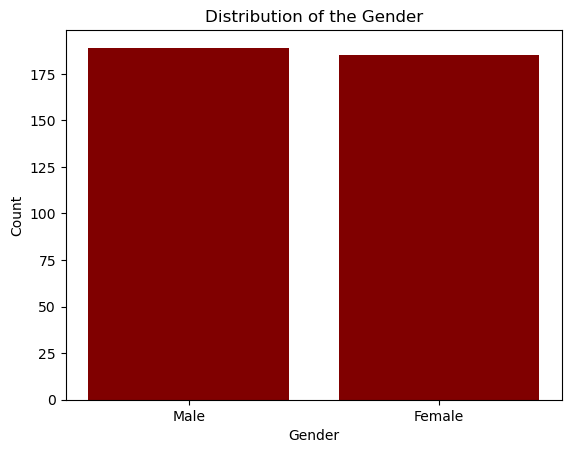

In [56]:
gender_counts = df['Gender'].value_counts()
plt.bar(gender_counts.index, gender_counts.values, color='maroon')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Distribution of the Gender')
plt.show()

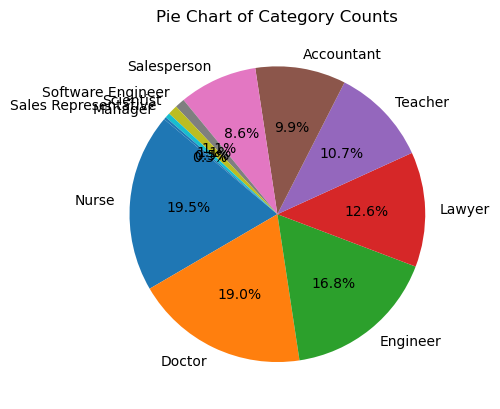

                                  Category  Count  Percentage
Occupation                                                   
Nurse                                Nurse     73   19.518717
Doctor                              Doctor     71   18.983957
Engineer                          Engineer     63   16.844920
Lawyer                              Lawyer     47   12.566845
Teacher                            Teacher     40   10.695187
Accountant                      Accountant     37    9.893048
Salesperson                    Salesperson     32    8.556150
Software Engineer        Software Engineer      4    1.069519
Scientist                        Scientist      4    1.069519
Sales Representative  Sales Representative      2    0.534759
Manager                            Manager      1    0.267380


In [57]:
occupation_counts = df['Occupation'].value_counts()
plt.pie(occupation_counts, labels=occupation_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Pie Chart of Category Counts')
plt.show()
total_count = len(df)
percentages = (occupation_counts / total_count) * 100
occupation_counts_df = pd.DataFrame({'Category': occupation_counts.index, 'Count': occupation_counts.values,'Percentage': percentages})
print(occupation_counts_df)

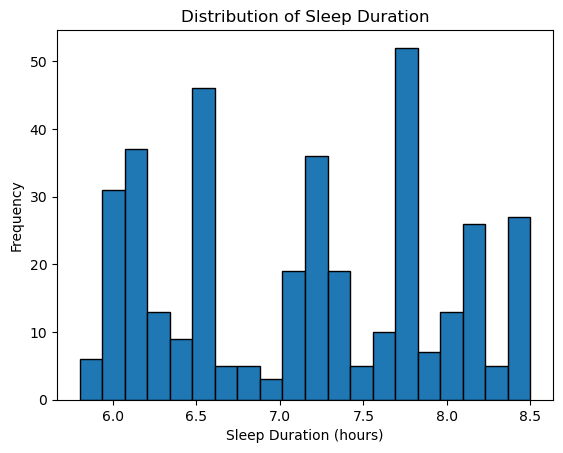

In [58]:
plt.hist(df['Sleep Duration'], bins=20, edgecolor='black')
plt.xlabel('Sleep Duration (hours)')
plt.ylabel('Frequency')
plt.title('Distribution of Sleep Duration')
plt.show()

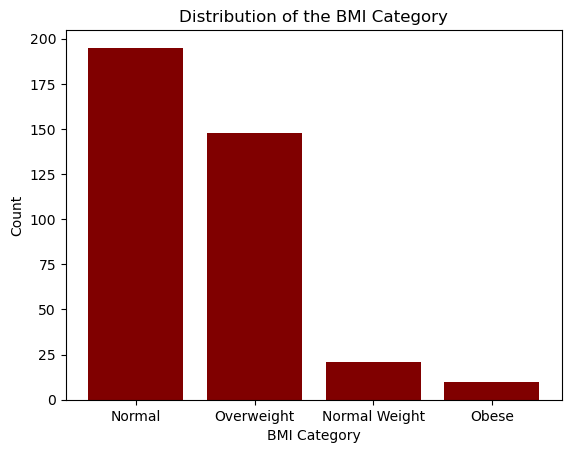

In [59]:
bmic_counts = df['BMI Category'].value_counts()
plt.bar(bmic_counts.index, bmic_counts.values, color='maroon')
plt.xlabel('BMI Category')
plt.ylabel('Count')
plt.title('Distribution of the BMI Category')
plt.show()

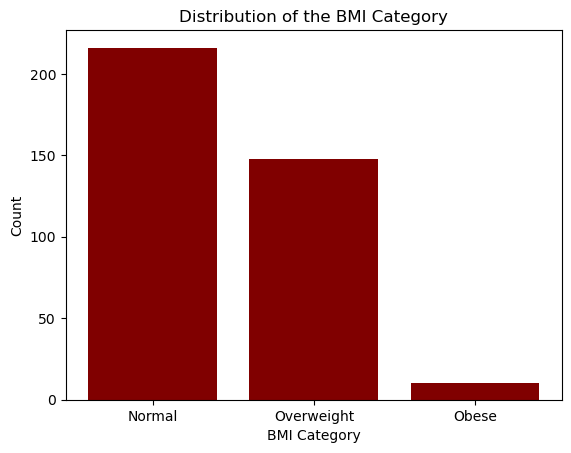

In [60]:
df['BMI Category'] = df['BMI Category'].replace('Normal Weight', 'Normal')
bmic_counts = df['BMI Category'].value_counts()
plt.bar(bmic_counts.index, bmic_counts.values, color='maroon')
plt.xlabel('BMI Category')
plt.ylabel('Count')
plt.title('Distribution of the BMI Category')
plt.show()

In [61]:
df['Sleep Disorder'].fillna('Normal', inplace=True)#fill missing values

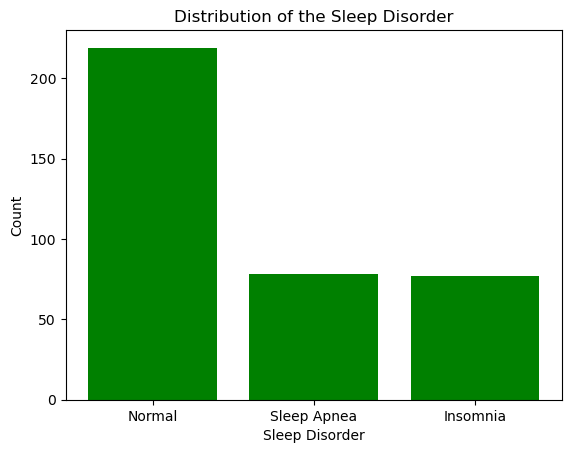

In [62]:
sleep = df['Sleep Disorder'].value_counts()
plt.bar(sleep.index, sleep.values, color='green')
plt.xlabel('Sleep Disorder')
plt.ylabel('Count')
plt.title('Distribution of the Sleep Disorder')
plt.show()

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 374 entries, 1 to 374
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   374 non-null    object 
 1   Age                      374 non-null    int64  
 2   Occupation               374 non-null    object 
 3   Sleep Duration           374 non-null    float64
 4   Quality of Sleep         374 non-null    int64  
 5   Physical Activity Level  374 non-null    int64  
 6   Stress Level             374 non-null    int64  
 7   BMI Category             374 non-null    object 
 8   Blood Pressure           374 non-null    object 
 9   Heart Rate               374 non-null    int64  
 10  Daily Steps              374 non-null    int64  
 11  Sleep Disorder           374 non-null    object 
dtypes: float64(1), int64(6), object(5)
memory usage: 38.0+ KB


In [64]:
X = df[['Age','Daily Steps','Heart Rate', 'Stress Level', 'Physical Activity Level', 'Sleep Duration','Quality of Sleep']]
y = df['Sleep Disorder']

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [66]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [67]:
model = LogisticRegression(multi_class='multinomial', max_iter=1000)
model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [68]:
y_pred = model.predict(X_test_scaled)

In [69]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.89


In [70]:
confusion_matrix(y_test, y_pred)

array([[13,  2,  1],
       [ 1, 42,  0],
       [ 3,  1, 12]])

In [71]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Insomnia       0.76      0.81      0.79        16
      Normal       0.93      0.98      0.95        43
 Sleep Apnea       0.92      0.75      0.83        16

    accuracy                           0.89        75
   macro avg       0.87      0.85      0.86        75
weighted avg       0.90      0.89      0.89        75



# Ordinal regression

https://www.statsmodels.org/devel/examples/notebooks/generated/ordinal_regression.html?highlight=ordinal

https://www.statsmodels.org/devel/generated/statsmodels.miscmodels.ordinal_model.OrderedResults.html#statsmodels.miscmodels.ordinal_model.OrderedResults

# Example 3: Treatment Planning

File  `plan.xlsx `

Variables:
- gender - gender (male, female)
- age - age in years
- duration - duration of illness in years
- educ - level of education (primary school, secondary school, high school)
- plan - agree with the need for planning the treatment:
    - absolutely disagree (AD)
    - rather disagree (RD)
    - neutral (N)
    - rather agree (RA)
    - absolutely agree (AA)

In [72]:
df = pd.read_excel('plan.xlsx')
df.head(25)

,gender,age,duration,educ,plan
0,female,27,4,secondary school,neutral
1,female,40,4,primary school,absolutely agree
2,male,38,4,primary school,rather agree
3,female,35,1,secondary school,rather disagree
4,female,35,1,primary school,rather agree
5,male,33,2,primary school,rather disagree
6,female,29,2,secondary school,rather agree
7,female,30,2,primary school,neutral
8,female,44,1,primary school,rather disagree
9,female,46,3,primary school,absolutely disagree


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   gender    85 non-null     object
 1   age       85 non-null     int64 
 2   duration  85 non-null     int64 
 3   educ      85 non-null     object
 4   plan      85 non-null     object
dtypes: int64(2), object(3)
memory usage: 3.4+ KB


## Dependent Variable

In [74]:
df['plan'].value_counts()

plan
absolutely disagree    24
neutral                18
rather disagree        18
rather agree           16
absolutely agree        9
Name: count, dtype: int64

In [75]:
def plan_recode(x):
    if x=='absolutely disagree':
        return 1
    elif x=='rather disagree':
        return 2
    elif x=='neutral':
        return 3
    elif x=='rather agree':
        return 4
    elif x=='absolutely agree':
        return 5

In [76]:
df['plan_num'] = df['plan'].apply(plan_recode)
df.head()

,gender,age,duration,educ,plan,plan_num
0,female,27,4,secondary school,neutral,3
1,female,40,4,primary school,absolutely agree,5
2,male,38,4,primary school,rather agree,4
3,female,35,1,secondary school,rather disagree,2
4,female,35,1,primary school,rather agree,4


In [77]:
df['plan_num'].value_counts()

plan_num
1    24
3    18
2    18
4    16
5     9
Name: count, dtype: int64

## Independent Variables

In [79]:
df['gender']=df['gender'].replace('male', 1)
df['gender']=df['gender'].replace('female', 0)  # reference group
df['gender'].value_counts()

gender
1    44
0    41
Name: count, dtype: int64

In [80]:
df

,gender,age,duration,educ,plan,plan_num
0,0,27,4,secondary school,neutral,3
1,0,40,4,primary school,absolutely agree,5
2,1,38,4,primary school,rather agree,4
3,0,35,1,secondary school,rather disagree,2
4,0,35,1,primary school,rather agree,4
...,...,...,...,...,...,...
80,0,58,8,high school,rather disagree,2
81,0,59,8,secondary school,rather disagree,2
82,1,56,9,high school,rather disagree,2
83,1,74,9,primary school,neutral,3


In [81]:
df['age'].describe()

count    85.000000
mean     47.894118
std      14.227759
min      25.000000
25%      37.000000
50%      46.000000
75%      57.000000
max      80.000000
Name: age, dtype: float64

In [82]:
df['duration'].describe()

count    85.000000
mean     11.505882
std       7.572858
min       1.000000
25%       4.000000
50%      12.000000
75%      18.000000
max      30.000000
Name: duration, dtype: float64

In [84]:
df['educ'].value_counts()  # high school - reference group

educ
primary school      53
secondary school    18
high school         14
Name: count, dtype: int64

In [85]:
educ_dummies=pd.get_dummies(df.educ, prefix='educ', prefix_sep='_', dtype=int)
educ_dummies.head()

,educ_high school,educ_primary school,educ_secondary school
0,0,0,1
1,0,1,0
2,0,1,0
3,0,0,1
4,0,1,0


In [86]:
df = pd.concat([df, educ_dummies], axis=1) 
df

,gender,age,duration,educ,plan,plan_num,educ_high school,educ_primary school,educ_secondary school
0,0,27,4,secondary school,neutral,3,0,0,1
1,0,40,4,primary school,absolutely agree,5,0,1,0
2,1,38,4,primary school,rather agree,4,0,1,0
3,0,35,1,secondary school,rather disagree,2,0,0,1
4,0,35,1,primary school,rather agree,4,0,1,0
...,...,...,...,...,...,...,...,...,...
80,0,58,8,high school,rather disagree,2,1,0,0
81,0,59,8,secondary school,rather disagree,2,0,0,1
82,1,56,9,high school,rather disagree,2,1,0,0
83,1,74,9,primary school,neutral,3,0,1,0


# Ordinal Regression

In [87]:
mod_log = OrderedModel(df['plan_num'],
                        df[['gender', 'age', 'duration', 'educ_primary school', 'educ_secondary school']],
                        distr='logit')

res_log = mod_log.fit(method='bfgs')
print(res_log.summary())

Optimization terminated successfully.
         Current function value: 1.483696
         Iterations: 29
         Function evaluations: 32
         Gradient evaluations: 32
                             OrderedModel Results                             
Dep. Variable:               plan_num   Log-Likelihood:                -126.11
Model:                   OrderedModel   AIC:                             270.2
Method:            Maximum Likelihood   BIC:                             292.2
Date:                Wed, 29 Oct 2025                                         
Time:                        13:31:07                                         
No. Observations:                  85                                         
Df Residuals:                      76                                         
Df Model:                           5                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------

In [88]:
predicted = res_log.model.predict(res_log.params, exog=df[['gender', 'age', 'duration', 'educ_primary school', 'educ_secondary school']])
predicted

array([[0.13393676, 0.16880539, 0.24855556, 0.27653826, 0.17216404],
       [0.33455847, 0.25076775, 0.2144452 , 0.14010342, 0.06012516],
       [0.43970585, 0.24811698, 0.17395672, 0.09885107, 0.03936938],
       [0.17488562, 0.19818328, 0.25433971, 0.24084072, 0.13175068],
       [0.33681671, 0.25096529, 0.21360614, 0.1390564 , 0.05955545],
       [0.43174949, 0.24908284, 0.17704721, 0.1015088 , 0.04061166],
       [0.14998985, 0.18129838, 0.25237382, 0.26216981, 0.15416814],
       [0.30209613, 0.24649508, 0.22613085, 0.15611514, 0.06916279],
       [0.38549055, 0.25235114, 0.19504115, 0.11834759, 0.04876957],
       [0.37651934, 0.25248971, 0.19851169, 0.12191434, 0.05056492],
       [0.17333628, 0.19721602, 0.25433411, 0.24212548, 0.13298811],
       [0.38204408, 0.25242442, 0.19637602, 0.11970537, 0.04945011],
       [0.39879715, 0.25183904, 0.18987359, 0.1132463 , 0.04624392],
       [0.5156743 , 0.23365419, 0.14495137, 0.07639868, 0.02932147],
       [0.5156743 , 0.23365419, 0.

# Confusion Matrix

In [89]:
cm = res_log.pred_table()
cm

row_0,0,1,2,3,4,All
col_0,,,,,,
0,21,0,3,0,0,24
1,12,0,4,2,0,18
2,9,0,4,5,0,18
3,6,0,2,7,1,16
4,5,0,1,3,0,9
All,53,0,14,17,1,85


### Saving the predicted probabilities of each event for each observation

In [90]:
predicted_probabilities = pd.DataFrame(predicted)
predicted_probabilities.columns = ['AD', 'RD', 'N', 'RA', 'AA']
predicted_probabilities

,AD,RD,N,RA,AA
0,0.133937,0.168805,0.248556,0.276538,0.172164
1,0.334558,0.250768,0.214445,0.140103,0.060125
2,0.439706,0.248117,0.173957,0.098851,0.039369
3,0.174886,0.198183,0.254340,0.240841,0.131751
4,0.336817,0.250965,0.213606,0.139056,0.059555
...,...,...,...,...,...
80,0.115869,0.153106,0.241113,0.292858,0.197054
81,0.216600,0.220418,0.250151,0.208628,0.104203
82,0.163919,0.191103,0.253988,0.250062,0.140928
83,0.596289,0.209416,0.115768,0.057216,0.021311


In [91]:
#the sum of all the probabilities is 1
predicted_probabilities['AD'] + predicted_probabilities['RD'] + predicted_probabilities['N'] + predicted_probabilities['RA'] + predicted_probabilities['AA']

0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
     ... 
80    1.0
81    1.0
82    1.0
83    1.0
84    1.0
Length: 85, dtype: float64

In [92]:
predicted_probabilities['predicted_group'] = predicted_probabilities.idxmax(axis=1)
predicted_probabilities
# predicted value of the dependent variable

,AD,RD,N,RA,AA,predicted_group
0,0.133937,0.168805,0.248556,0.276538,0.172164,RA
1,0.334558,0.250768,0.214445,0.140103,0.060125,AD
2,0.439706,0.248117,0.173957,0.098851,0.039369,AD
3,0.174886,0.198183,0.254340,0.240841,0.131751,N
4,0.336817,0.250965,0.213606,0.139056,0.059555,AD
...,...,...,...,...,...,...
80,0.115869,0.153106,0.241113,0.292858,0.197054,RA
81,0.216600,0.220418,0.250151,0.208628,0.104203,N
82,0.163919,0.191103,0.253988,0.250062,0.140928,N
83,0.596289,0.209416,0.115768,0.057216,0.021311,AD


In [93]:
res = pd.concat([df, predicted_probabilities['predicted_group']], axis=1)
res  # add the predicted value to the original dataframe

,gender,age,duration,educ,plan,plan_num,educ_high school,educ_primary school,educ_secondary school,predicted_group
0,0,27,4,secondary school,neutral,3,0,0,1,RA
1,0,40,4,primary school,absolutely agree,5,0,1,0,AD
2,1,38,4,primary school,rather agree,4,0,1,0,AD
3,0,35,1,secondary school,rather disagree,2,0,0,1,N
4,0,35,1,primary school,rather agree,4,0,1,0,AD
...,...,...,...,...,...,...,...,...,...,...
80,0,58,8,high school,rather disagree,2,1,0,0,RA
81,0,59,8,secondary school,rather disagree,2,0,0,1,N
82,1,56,9,high school,rather disagree,2,1,0,0,N
83,1,74,9,primary school,neutral,3,0,1,0,AD


In [94]:
res[['plan', 'predicted_group']].head(70)
# display real and predicted values

,plan,predicted_group
0,neutral,RA
1,absolutely agree,AD
2,rather agree,AD
3,rather disagree,N
4,rather agree,AD
...,...,...
65,absolutely disagree,AD
66,rather disagree,AD
67,neutral,RA
68,absolutely disagree,AD
